In [1]:
import sys
sys.path.append('/home/g/gaur/gaur/.local/lib/python3.8/site-packages')

In [ ]:
import numpy as np
import torch 
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris,load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers,IQPEmbedding
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

from sklearn import metrics
np.random.seed(42)

In [ ]:
X, y = load_diabetes(return_X_y=True, as_frame=False)

n = 442

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
#X = X[:500]
#y = y[:500]



X = SelectKBest(f_classif, k=4).fit_transform(X, y)
#print(X.shape)
#print(X[1])

# y is the blood glucose level one year after the base line test
# change y to binary y >= 185 diabetes, no otherwise

for i in range(len(y)):
    if (y[i] > 185):
        y[i] = 1
    else:
        y[i] = 0
        
#print(y)


# scaling the inputs is important since the embedding we use is periodic
#scaler = StandardScaler().fit(X)
#X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)


#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)
X_train, X_test, y_train, y_test = train_test_split(X , y_scaled)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

#clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test = scaler.transform(X_test)

#X  = np.concatenate((X_train, X_test), axis=0)
X.shape

In [346]:
def circuit(feature_vector,feature_vector_2,length):
    qml.AngleEmbedding(features=feature_vector, wires=range(length),rotation='Z')
    qml.adjoint(qml.AngleEmbedding(features=feature_vector_2, wires=range(length),rotation='Z'))
    #qml.IQPEmbedding(features=feature_vector, wires=range(length),n_repeats=2)
    #qml.adjoint(qml.IQPEmbedding(features=feature_vector_2, wires=range(length),n_repeats=2))
    return qml.probs(wires=range(length))
n_qubits = len(X_train[0])
dev_kernel = qml.device("default.qubit", wires=n_qubits)

In [347]:

@qml.qnode(dev_kernel, interface="autograd")
def kernel(x1, x2):
    """The quantum kernel."""
    u_1 = qml.matrix(circuit)(x1,x2,len(x1))
    u_2 = u_1.conjugate().transpose()
    projector = u_1+u_2
    return qml.expval(qml.Hermitian(projector,wires=range(n_qubits)))

In [6]:
def kernel_matrix_2(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[np.exp(-2 + kernel(a, b)) for b in B] for a in A])

In [348]:
def kernel_matrix_rectangular(A, B,i):
    #sigma=0.1
    gamma = 1
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    res = np.zeros((1,len(B)))
 #   for i in range(len(A)):
    for j in range(len(B)):
        # if ( i < j):
        # res[0,j] =  np.exp(- gamma*(2 - kernel(A[0], B[j]))**2) # np.exp((-2 + kernel(A[0], B[j])))
        res[0,j] =  np.exp(- gamma*(2 - kernel(A[0], B[j]))**2 )
         #   else:
             #   res[i,j] = res[j,i]
    return list(res[0])
def kernel_matrix_square(A, B, i):
    gamma = 1
    res = np.zeros((1,len(B)))
    for j in range(i+1,len(B)):
        # res[0,j] =  np.exp(- gamma*(2 - kernel(A[0], B[j]))**2) # np.exp((-2+kernel(A[0],B[j])))
        res[0,j] =  np.exp(- gamma*(2 - kernel(A[0], B[j]))**2 )
    return list(res[0])

In [361]:
import time
import joblib
def new_kernel_par(A,B):
    ans = np.zeros((len(A),len(B)))
    s = time.time()
    # kernel_matrix(X_train[0], X_train)
    if len(A)==len(B):
        ans = joblib.Parallel(n_jobs=4)(joblib.delayed(kernel_matrix_square)([A[i]],B,i) for i in range(len(A)))
        #print(ans)
        e = time.time()
        ans = np.array(ans)
        #print(ans.shape)
        ans=ans+ans.T+np.eye(len(A),len(B))
        #print(ans)
    else:
        ans = joblib.Parallel(n_jobs=4)(joblib.delayed(kernel_matrix_rectangular)([A[i]],B,i) for i in range(len(A)))
        #print(ans)
        e = time.time()
        ans = np.array(ans)
        #print(ans.shape)
        #ans=ans+ans.T+np.eye(len(A),len(B))
        #print(ans)
   # ti=e-s
    # print((e-s)/(40)* 900*10**6/2 /3600/24)
    # print(1)
    return ans   #, (e-s)/(400-20)* 900*10**6/2 /3600/24

In [362]:
def qsvm(Xtrain,ytrain):
    svm = SVC(kernel=new_kernel_par).fit(Xtrain, ytrain)
    return svm

In [363]:
svc = qsvm(X_train,y_train)

In [364]:
predictions = svc.predict(X_test)
accuracy_score(predictions, y_test)

0.7747747747747747

In [352]:
predictions = svc.predict(X_test)
accuracy_score(predictions, y_test)

0.7477477477477478

In [344]:
predictions = svc.predict(X_test)
accuracy_score(predictions, y_test)

0.8018018018018018

In [315]:
predictions = svc.predict(X_test)
accuracy_score(predictions, y_test)

0.7027027027027027

In [288]:
predictions = svc.predict(X_test)
accuracy_score(predictions, y_test)

0.7567567567567568

In [296]:
predictions = svc.predict(X_test)
accuracy_score(predictions, y_test)

0.7747747747747747

In [10]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10]}
# Create an SVM classifier with a radial basis function (RBF) kernel
svm = SVC(kernel='rbf')
# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=2)
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
# Make predictions on the test data using the best model
y_pred = grid_search.predict(X_test)
#y_pred = grid_search.predict(X)
#predictions = svm.predict(sxtes)
accuracy = accuracy_score(y_test, y_pred)
#accuracy = accuracy_score(y, y_pred)
print("Accuracy for svm:", accuracy)

Best Parameters: {'C': 1, 'gamma': 0.1}
Accuracy for svm: 0.8468468468468469


In [12]:
# RBF kernel


# >>> cross_val_score(clf, X, y, cv=cv)

X = X[:100]
y = y[:100]

lasso = SVC(kernel='rbf')
clf = make_pipeline(preprocessing.StandardScaler(), lasso)
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

cv_results1 = cross_validate(clf, X, y, cv=cv)
sorted(cv_results1.keys())
['fit_time', 'score_time', 'test_score']
print("acc for 10-fold RBF ",cv_results1['test_score'], np.mean(cv_results1['test_score']))

acc for 10-fold RBF  [0.8 0.9 0.8 0.9 0.9 0.6 0.8 0.9 0.7 0.8 0.8 0.9 0.7 1.  0.8 1.  0.6 0.8
 0.8 0.7 0.8 0.8 0.7 1.  0.7 0.8 0.7 0.9 0.8 1.  0.9 0.7 0.9 0.7 0.9 0.9
 0.8 0.8 0.9 0.8 0.9 0.9 0.8 0.6 0.7 1.  0.7 1.  0.7 0.9 0.5 1.  0.9 0.8
 0.9 1.  0.7 0.5 1.  0.9 0.6 1.  0.8 0.7 1.  0.9 0.6 0.9 0.9 0.8 1.  0.9
 0.6 0.8 0.6 1.  0.7 0.9 1.  0.8 0.9 0.7 0.8 0.9 0.7 0.9 0.7 0.8 1.  0.9
 0.9 0.9 1.  0.9 0.6 0.9 0.7 1.  0.8 0.7] 0.823


In [356]:
# angle embedding


# >>> cross_val_score(clf, X, y, cv=cv)

X = X[:100]
y = y[:100]

lasso = SVC(kernel= new_kernel_par)#newhttps://jupyter.scinet.utoronto.ca/user/gaur/notebooks/Siddartha/Pima_diabetes.ipynb#_kernel_par)
clf = make_pipeline(preprocessing.StandardScaler(), lasso)
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
cv_results = cross_validate(clf, X, y, cv=cv)
sorted(cv_results.keys())
['fit_time', 'score_time', 'test_score']
print("acc for 10-fold Qkernel angle embedding is ",cv_results['test_score'],np.mean(cv_results['test_score']))

KeyboardInterrupt: 

In [17]:
# # IQP Embedding
# X = X
# y = y
# lasso = SVC(kernel=new_kernel_par)
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
# cv_results2 = cross_validate(lasso, X, y, cv=cv)
# sorted(cv_results2.keys())
# ['fit_time', 'score_time', 'test_score']
# print("acc for 10-fold Qkernel IQP embedding depth 1 is ",sum(cv_results2['test_score'])/10)

acc for 10-fold Qkernel IQP embedding depth 1 is  0.7799999999999999


In [21]:
# # IQP Embedding with depth 2
# X = X
# y = y
# lasso = SVC(kernel=new_kernel_par)
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
# cv_results3 = cross_validate(lasso, X, y, cv=cv)
# sorted(cv_results3.keys())
# ['fit_time', 'score_time', 'test_score']
# print("acc for 10-fold Qkernel IQP embedding depth 2 is ",sum(cv_results3['test_score'])/10)

acc for 10-fold Qkernel IQP embedding depth 2 is  0.7799999999999999


In [ ]:
X.shape

(<Figure size 900x500 with 1 Axes>, <Axes: >)

[3.15249024e-03 1.00358905e-02 7.82863697e-02 9.03673727e-04
 6.49822403e-02 1.26346502e-02 1.20907188e-03 3.16048176e-05
 5.97508918e-01 3.28751055e-02 6.84386285e-02 5.25256557e-04
 1.14490148e-01 1.45370806e-02 3.88787896e-04 8.39298071e-08]


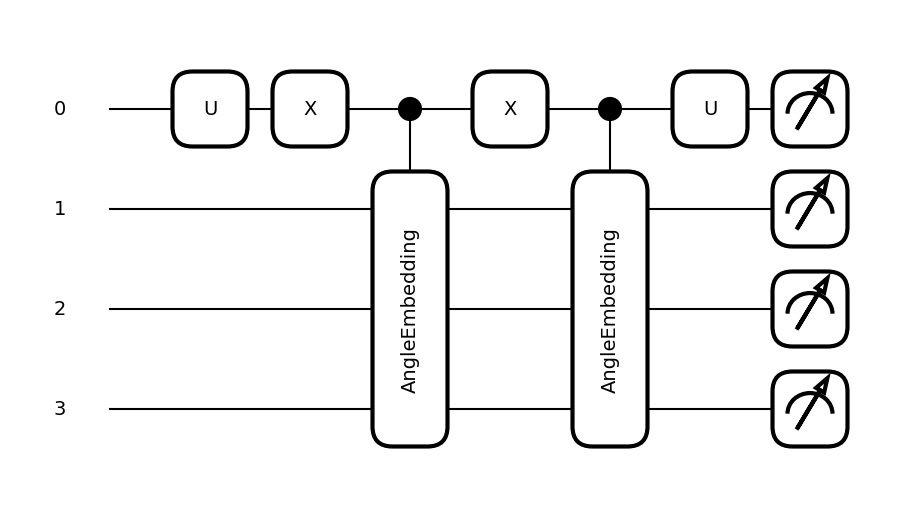

In [357]:
import pennylane as qml
from pennylane import numpy as np

# Define the custom unitary matrix
custom_matrix = np.array([[1, -1], [1, 1]])
custom_matrix = custom_matrix/(2**0.5)

# Define the quantum circuit
dev = qml.device("default.qubit", wires=4,shots = None)
@qml.qnode(dev)
def circuit(x1,x2,length):
    # Apply the custom gate to the qubit
    #k = True
    #while k == True:
    qml.QubitUnitary(custom_matrix, wires=0)
    qml.PauliX(wires = 0)
    qml.ctrl(qml.AngleEmbedding, control=0)(features=x1, wires=range(1,length+1))
    qml.PauliX(wires = 0)
    qml.ctrl(qml.AngleEmbedding, control=0)(features=x2, wires=range(1,length+1))#,n_repeats=1)
    qml.QubitUnitary(custom_matrix, wires = 0)
    #qml.PauliX(0)
    #m_0 = qml.measure(0)
    #print(m_0)
    #if m_0 == 0:
    #    k = False
    identity = np.array([[1,0],[0,1]])
    for i in range(length-1):
        identity = np.kron(identity,np.array([[1,0],[0,0]]))
    #return #qml.cond(m_0 == 0,qml.expval(qml.Hermitian))(identity,wires=range(1,length+1))
    return qml.probs()
# Print the resulting state after applying the gate
print(qml.draw_mpl(circuit)(X_train[0],X_train[1],len(X_train[0])))
print('')
#print(qml.matrix(circuit)(X_train[0],X_train[1],len(X_train[0])))
print(circuit(X_train[0],X_train[1],len(X_train[0])))

In [358]:
def kernel_value(x1,x2):
    #state = circuit(x1,x2,len(x1))
    #state[len(state)//2:] = 0
    #state[1::2] = 0
    #state = state / np.linalg.norm(state)
    #np.linalg.norm(state)
    probs = circuit(x1,x2,len(x1))
    return 4*np.sum(probs[:len(probs)//2])
    #return 4*np.real(np.matmul(np.conjugate(np.transpose(state)),state))

In [360]:
def kernel_matrix_rectangular(A, B,i):
    #sigma=0.1
    gamma = 1
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    res = np.zeros((1,len(B)))
 #   for i in range(len(A)):
    for j in range(len(B)):
        # if ( i < j):
        # res[0,j] =  np.exp(- gamma*(2 - kernel(A[0], B[j]))**2) # np.exp((-2 + kernel(A[0], B[j])))
        #res[0,j] =  np.exp(- gamma*(2 - kernel(A[0], B[j]))**2 )
        res[0,j] = np.exp(- gamma*kernel_value(A[0],B[j])**2)
         #   else:
             #   res[i,j] = res[j,i]
    return list(res[0])
def kernel_matrix_square(A, B, i):
    gamma = 1
    res = np.zeros((1,len(B)))
    for j in range(i+1,len(B)):
        # res[0,j] =  np.exp(- gamma*(2 - kernel(A[0], B[j]))**2) # np.exp((-2+kernel(A[0],B[j])))
        #res[0,j] =  np.exp(- gamma*(2 - kernel(A[0], B[j]))**2 )
        res[0,j] = np.exp(- gamma*kernel_value(A[0],B[j])**2)
    return list(res[0])

In [285]:
state = circuit(X_train[0],X_train[1],len(X_train[0]))
print(state**2)
state_2 = [i**2 for i in state[:len(state)//2]]
sum(state_2)

[ 1.68258156e-03+0.j  0.00000000e+00+0.j -3.09956177e-05+0.j
  0.00000000e+00+0.j -1.58951507e-01-0.j  0.00000000e+00+0.j
  6.26370289e-02-0.j  0.00000000e+00+0.j  5.57854330e-01+0.j
  0.00000000e+00+0.j -2.15098034e-01-0.j  0.00000000e+00+0.j
 -1.85602499e-03+0.j  0.00000000e+00+0.j  1.88949893e-03+0.j
  0.00000000e+00+0.j]


tensor(-0.09466289+0.j, requires_grad=True)